In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization, ZeroPadding2D
from keras.datasets import mnist
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

##### **Dataset**

In [2]:
# Load the data
(X, y), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


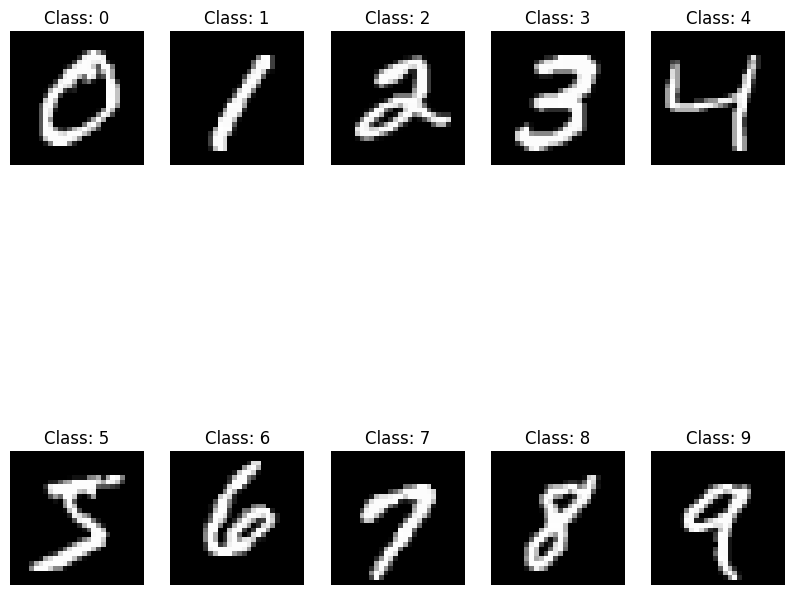

In [3]:
# Create a list to store indices of the first occurrence of each class
indices = []

# Loop over the classes
for i in range(10):
    # Find the index of the first occurrence of this class
    index = np.where(y == i)[0][0]
    indices.append(index)

# Plot one sample for each class
plt.figure(figsize=(10, 10))
for i, index in enumerate(indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[index], cmap='gray')
    plt.title(f"Class: {y[index]}")
    plt.axis('off')
plt.show()

In [4]:
# One-hot encode the target variable
y = to_categorical(y)
y_test = to_categorical(y_test)

In [5]:
# Split the data into training and valid sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
print("Training data dimensions:", X_train.shape)
print("Validation data dimensions:",X_val.shape)
print("Testing data dimensions:",X_test.shape)

Training data dimensions: (48000, 28, 28)
Validation data dimensions: (12000, 28, 28)
Testing data dimensions: (10000, 28, 28)


It means that 48k 28x28 pictures exist in training data, 12k 28x28 pictures for validation data and 10k 28x28 pictures for testing data.

##### **Convolutional Neural Network**
`Structure`: <br>
1. Convolutional: 64 filters, kernel size=3x3
2. Batch Normalization
3. Max Pooling: stride=2

4. Convolutional -> filters and kernel size will specify by cross validation. (filters = 16 or 32 , kernel size = 3x3 or 5x5)
5. Batch Normalization
6. Max Pooling: stride=2

7. <i>Flatten layer -> to converting CNN output from 2D to 1D and use it as a input of fully connected layer </i>
8. Fully Connected: 128 neuron
9. Fully Connected: 64 neuron
10. Fully Connected 10 neuron -> because of the number of classes

In [7]:
def create_model(conv2_filters, conv2_kernel_size):
  model = Sequential()
  model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(28,28,1)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

  model.add(Conv2D(conv2_filters, kernel_size=conv2_kernel_size, activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(10, activation='softmax'))

  return model

##### **Cross Validation to determine second Conv layer**


In [12]:
options = [(32,3),(32,5),(16,3),(16,5)]
for filnum, kersize in options:
  # Compile the model
  print(f"filters: {filnum}, kernel size: {kersize}")
  model = create_model(filnum, kersize)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  # Train the model and save the history
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3)

filters: 32, kernel size: 3
Epoch 1/3
1500/1500 [==============================] - 87s 57ms/step - loss: 0.1158 - accuracy: 0.9644 - val_loss: 0.0562 - val_accuracy: 0.9841
Epoch 2/3
1500/1500 [==============================] - 81s 54ms/step - loss: 0.0463 - accuracy: 0.9857 - val_loss: 0.0558 - val_accuracy: 0.9826
Epoch 3/3
1500/1500 [==============================] - 80s 54ms/step - loss: 0.0328 - accuracy: 0.9896 - val_loss: 0.0444 - val_accuracy: 0.9870
filters: 32, kernel size: 5
Epoch 1/3
1500/1500 [==============================] - 105s 69ms/step - loss: 0.1123 - accuracy: 0.9653 - val_loss: 0.0669 - val_accuracy: 0.9801
Epoch 2/3
1500/1500 [==============================] - 102s 68ms/step - loss: 0.0445 - accuracy: 0.9869 - val_loss: 0.0973 - val_accuracy: 0.9737
Epoch 3/3
1500/1500 [==============================] - 101s 67ms/step - loss: 0.0336 - accuracy: 0.9898 - val_loss: 0.0531 - val_accuracy: 0.9847
filters: 16, kernel size: 3
Epoch 1/3
1500/1500 [======================

The first try has more accuracy in validation phase than other tries, so we'll set second conv layer by 32 filters with 3x3 size.

In [13]:
# Compile the model with the best filter and the best kernel size
model = create_model(32, 3)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model and save the history
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3)

Epoch 1/3
1500/1500 [==============================] - 80s 52ms/step - loss: 0.1212 - accuracy: 0.9626 - val_loss: 0.0582 - val_accuracy: 0.9830
Epoch 2/3
1500/1500 [==============================] - 77s 51ms/step - loss: 0.0442 - accuracy: 0.9863 - val_loss: 0.0609 - val_accuracy: 0.9814
Epoch 3/3
1500/1500 [==============================] - 80s 54ms/step - loss: 0.0324 - accuracy: 0.9898 - val_loss: 0.0543 - val_accuracy: 0.9856


In [14]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

313/313 - 5s - loss: 0.0454 - accuracy: 0.9880 - 5s/epoch - 16ms/step


##### **About Dropout...**

Dropout is a regularization technique that helps prevent overfitting. During training, dropout randomly sets a fraction of the input units to 0 at each update, which helps
to prevent overfitting by making sure that the model is robust and can generalize well from the training data to unseen data.

The model’s performance on the validation set is good as on the training set, in other words, overfitting didn't occur so it's not necessary to adding dropout.


In [15]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 26, 26, 64)        640       
                                                                 
 batch_normalization_16 (Ba  (None, 26, 26, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 13, 13, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 11, 11, 32)        18464     
                                                                 
 batch_normalization_17 (Ba  (None, 11, 11, 32)        128       
 tchNormalization)                                               
                                                      

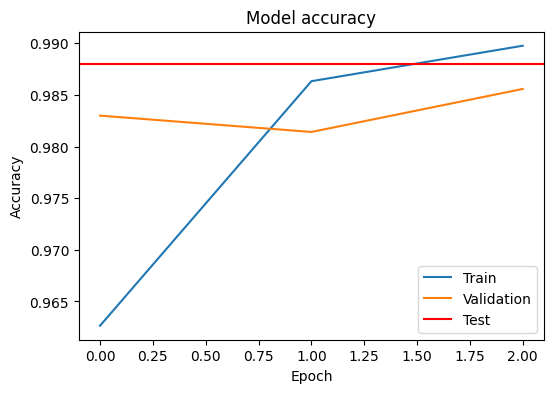

In [16]:
# Plot training & validation accuracy values
plt.figure(figsize=[6,4])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axhline(y=test_acc, color='r', linestyle='-')  # Add test accuracy to plot
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation', 'Test'])
plt.show()

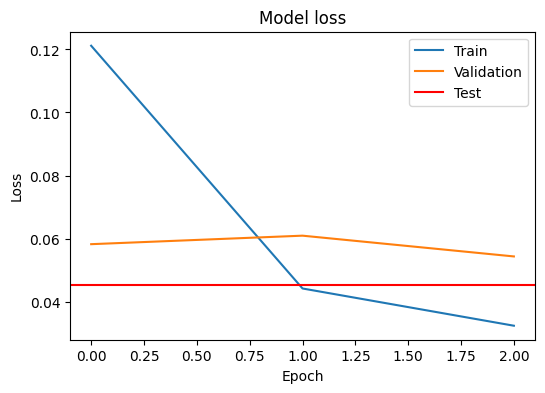

In [17]:
# Plot training & validation loss values
plt.figure(figsize=[6,4])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axhline(y=test_loss, color='r', linestyle='-')  # Add test loss to plot
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation', 'Test'])
plt.show()

In [18]:
# Create a DataFrame for the training, validation, and test loss and accuracy
results = pd.DataFrame({
    'Stage': ['Training', 'Validation', 'Test'],
    'Loss': [history.history['loss'][-1], history.history['val_loss'][-1], test_loss],
    'Accuracy': [history.history['accuracy'][-1], history.history['val_accuracy'][-1], test_acc]
})

results

,Stage,Loss,Accuracy
0,Training,0.032356,0.989771
1,Validation,0.054337,0.985583
2,Test,0.045397,0.988000


313/313 [==============================] - 4s 11ms/step


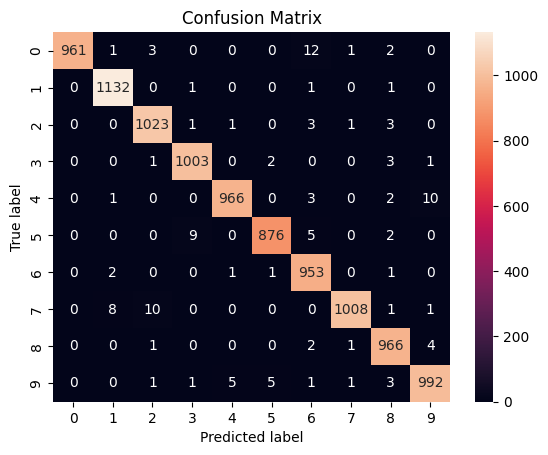

In [19]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(confusion_mtx, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()